In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import pickle
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsummary import summary

# Model Training

## Initializing the model

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        skip_connection = self.skip(x)
        
        # Main path
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # Skip connection
        out = x + skip_connection
        
        return self.relu(out)


In [3]:
class ResNetMini(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Initial stem convolution
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.gelu = nn.GELU()

        # Network stages with increasing channels and downsampling
        self.layer1 = self.resnet_layer(48, num_blocks=16, stride=1)  # High-depth initial layer
        self.layer2 = self.resnet_layer(64, num_blocks=8, stride=2)   # First downsampling
        self.layer3 = self.resnet_layer(152, num_blocks=4, stride=2)  # Channel expansion
        self.layer4 = self.resnet_layer(256, num_blocks=2, stride=2)  # Final features

        # Classification head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def resnet_layer(self, out_channels, num_blocks, stride):
        layers = [ResidualBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        

        x = self.avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        out = self.fc(x)
        
        return out


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetMini()
model.to(device)
summary(model,input_size = (3,32,32)) # Number of parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              GELU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]           1,584
       BatchNorm2d-5           [-1, 48, 32, 32]              96
            Conv2d-6           [-1, 48, 32, 32]          13,872
       BatchNorm2d-7           [-1, 48, 32, 32]              96
              GELU-8           [-1, 48, 32, 32]               0
            Conv2d-9           [-1, 48, 32, 32]          20,784
      BatchNorm2d-10           [-1, 48, 32, 32]              96
             ReLU-11           [-1, 48, 32, 32]               0
    ResidualBlock-12           [-1, 48, 32, 32]               0
           Conv2d-13           [-1, 48, 32, 32]          20,784
      BatchNorm2d-14           [-1, 48,

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616))
])

In [6]:
batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
model = ResNetMini(num_classes=10)

if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs detected!")
    model = nn.DataParallel(model)  # Parallelize across GPUs

model.to(device) 

# Training config
num_epochs = 60
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0008) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) 

# Metric tracking 
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_f1s, test_f1s = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []  

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Training steps
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Loss and accuracy 
        running_loss += loss.item() * inputs.size(0) 
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix(loss=f"{running_loss/total:.4f}", accuracy=f"{100.*correct/total:.2f}%")

    # Calculate epoch training metrics
    epoch_train_loss = running_loss / total
    epoch_train_acc = 100. * correct / total
    epoch_train_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_train_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_train_f1 = f1_score(all_labels, all_preds, average='macro')

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_precisions.append(epoch_train_precision)
    train_recalls.append(epoch_train_recall)
    train_f1s.append(epoch_train_f1)

    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  
        pbar_test = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]")
        for inputs, labels in pbar_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar_test.set_postfix(loss=f"{test_loss/total_test:.4f}", accuracy=f"{100.*correct_test/total_test:.2f}%")

    # Calculate epoch test metrics
    epoch_test_loss = test_loss / total_test
    epoch_test_acc = 100. * correct_test / total_test
    epoch_test_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_test_recall = recall_score(all_labels, all_preds, average='macro')
    epoch_test_f1 = f1_score(all_labels, all_preds, average='macro')

    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)
    test_precisions.append(epoch_test_precision)
    test_recalls.append(epoch_test_recall)
    test_f1s.append(epoch_test_f1)

    scheduler.step() 

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
    print(f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")
    print(f"Train Precision: {epoch_train_precision:.4f}, Train Recall: {epoch_train_recall:.4f}, Train F1: {epoch_train_f1:.4f}")
    print(f"Test Precision: {epoch_test_precision:.4f}, Test Recall: {epoch_test_recall:.4f}, Test F1: {epoch_test_f1:.4f}\n")

# Save final model
torch.save(model.state_dict(), 'resnet_mini_cifar10_finetuned_v1.pth')
print('Finished Training')


Epoch 1/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.11it/s, accuracy=49.16%, loss=1.3537]



Epoch [1/60] Summary:
Train Loss: 1.6905, Train Acc: 36.65%
Test Loss: 1.3537, Test Acc: 49.16%
Train Precision: 0.3607, Train Recall: 0.3665, Train F1: 0.3611
Test Precision: 0.5243, Test Recall: 0.4916, Test F1: 0.4894



Epoch 2/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.60it/s, accuracy=59.87%, loss=1.1116]



Epoch [2/60] Summary:
Train Loss: 1.3119, Train Acc: 52.01%
Test Loss: 1.1116, Test Acc: 59.87%
Train Precision: 0.5151, Train Recall: 0.5201, Train F1: 0.5166
Test Precision: 0.6147, Test Recall: 0.5987, Test F1: 0.5953



Epoch 3/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.28it/s, accuracy=65.59%, loss=0.9914]



Epoch [3/60] Summary:
Train Loss: 1.1144, Train Acc: 60.34%
Test Loss: 0.9914, Test Acc: 65.59%
Train Precision: 0.5997, Train Recall: 0.6034, Train F1: 0.6012
Test Precision: 0.6798, Test Recall: 0.6559, Test F1: 0.6526



Epoch 4/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.94it/s, accuracy=66.56%, loss=0.9562]



Epoch [4/60] Summary:
Train Loss: 0.9883, Train Acc: 64.80%
Test Loss: 0.9562, Test Acc: 66.56%
Train Precision: 0.6461, Train Recall: 0.6480, Train F1: 0.6469
Test Precision: 0.7190, Test Recall: 0.6656, Test F1: 0.6652



Epoch 5/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.06it/s, accuracy=71.17%, loss=0.8372]



Epoch [5/60] Summary:
Train Loss: 0.8875, Train Acc: 68.82%
Test Loss: 0.8372, Test Acc: 71.17%
Train Precision: 0.6868, Train Recall: 0.6882, Train F1: 0.6874
Test Precision: 0.7622, Test Recall: 0.7117, Test F1: 0.7156



Epoch 6/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.33it/s, accuracy=77.59%, loss=0.6569]



Epoch [6/60] Summary:
Train Loss: 0.8100, Train Acc: 71.40%
Test Loss: 0.6569, Test Acc: 77.59%
Train Precision: 0.7128, Train Recall: 0.7140, Train F1: 0.7133
Test Precision: 0.7761, Test Recall: 0.7759, Test F1: 0.7731



Epoch 7/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.95it/s, accuracy=79.97%, loss=0.5792]



Epoch [7/60] Summary:
Train Loss: 0.7428, Train Acc: 74.00%
Test Loss: 0.5792, Test Acc: 79.97%
Train Precision: 0.7393, Train Recall: 0.7400, Train F1: 0.7396
Test Precision: 0.8015, Test Recall: 0.7997, Test F1: 0.7973



Epoch 8/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.00it/s, accuracy=81.98%, loss=0.5264]



Epoch [8/60] Summary:
Train Loss: 0.6855, Train Acc: 76.01%
Test Loss: 0.5264, Test Acc: 81.98%
Train Precision: 0.7593, Train Recall: 0.7601, Train F1: 0.7596
Test Precision: 0.8251, Test Recall: 0.8198, Test F1: 0.8198



Epoch 9/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.89it/s, accuracy=82.95%, loss=0.5151]



Epoch [9/60] Summary:
Train Loss: 0.6371, Train Acc: 77.70%
Test Loss: 0.5151, Test Acc: 82.95%
Train Precision: 0.7765, Train Recall: 0.7770, Train F1: 0.7767
Test Precision: 0.8323, Test Recall: 0.8295, Test F1: 0.8286



Epoch 10/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.19it/s, accuracy=81.83%, loss=0.5137]



Epoch [10/60] Summary:
Train Loss: 0.5996, Train Acc: 79.17%
Test Loss: 0.5137, Test Acc: 81.83%
Train Precision: 0.7910, Train Recall: 0.7917, Train F1: 0.7912
Test Precision: 0.8309, Test Recall: 0.8183, Test F1: 0.8196



Epoch 11/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.28it/s, accuracy=83.68%, loss=0.4818]



Epoch [11/60] Summary:
Train Loss: 0.5643, Train Acc: 80.37%
Test Loss: 0.4818, Test Acc: 83.68%
Train Precision: 0.8032, Train Recall: 0.8037, Train F1: 0.8034
Test Precision: 0.8434, Test Recall: 0.8368, Test F1: 0.8376



Epoch 12/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.19it/s, accuracy=83.47%, loss=0.4703]



Epoch [12/60] Summary:
Train Loss: 0.5389, Train Acc: 81.12%
Test Loss: 0.4703, Test Acc: 83.47%
Train Precision: 0.8110, Train Recall: 0.8112, Train F1: 0.8111
Test Precision: 0.8445, Test Recall: 0.8347, Test F1: 0.8336



Epoch 13/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.04it/s, accuracy=86.01%, loss=0.4028]



Epoch [13/60] Summary:
Train Loss: 0.5128, Train Acc: 82.03%
Test Loss: 0.4028, Test Acc: 86.01%
Train Precision: 0.8200, Train Recall: 0.8203, Train F1: 0.8201
Test Precision: 0.8651, Test Recall: 0.8601, Test F1: 0.8593



Epoch 14/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.82it/s, accuracy=86.35%, loss=0.3925]



Epoch [14/60] Summary:
Train Loss: 0.4899, Train Acc: 82.97%
Test Loss: 0.3925, Test Acc: 86.35%
Train Precision: 0.8294, Train Recall: 0.8297, Train F1: 0.8295
Test Precision: 0.8643, Test Recall: 0.8635, Test F1: 0.8628



Epoch 15/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.29it/s, accuracy=88.07%, loss=0.3509]



Epoch [15/60] Summary:
Train Loss: 0.4708, Train Acc: 83.59%
Test Loss: 0.3509, Test Acc: 88.07%
Train Precision: 0.8356, Train Recall: 0.8359, Train F1: 0.8357
Test Precision: 0.8842, Test Recall: 0.8807, Test F1: 0.8817



Epoch 16/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.43it/s, accuracy=87.62%, loss=0.3614]



Epoch [16/60] Summary:
Train Loss: 0.4546, Train Acc: 84.19%
Test Loss: 0.3614, Test Acc: 87.62%
Train Precision: 0.8417, Train Recall: 0.8419, Train F1: 0.8417
Test Precision: 0.8784, Test Recall: 0.8762, Test F1: 0.8760



Epoch 17/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.30it/s, accuracy=86.77%, loss=0.3829]



Epoch [17/60] Summary:
Train Loss: 0.4291, Train Acc: 85.03%
Test Loss: 0.3829, Test Acc: 86.77%
Train Precision: 0.8501, Train Recall: 0.8503, Train F1: 0.8501
Test Precision: 0.8752, Test Recall: 0.8677, Test F1: 0.8695



Epoch 18/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.33it/s, accuracy=89.22%, loss=0.3256]



Epoch [18/60] Summary:
Train Loss: 0.4190, Train Acc: 85.39%
Test Loss: 0.3256, Test Acc: 89.22%
Train Precision: 0.8537, Train Recall: 0.8539, Train F1: 0.8537
Test Precision: 0.8916, Test Recall: 0.8922, Test F1: 0.8917



Epoch 19/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.47it/s, accuracy=89.04%, loss=0.3179]



Epoch [19/60] Summary:
Train Loss: 0.3958, Train Acc: 86.26%
Test Loss: 0.3179, Test Acc: 89.04%
Train Precision: 0.8624, Train Recall: 0.8626, Train F1: 0.8624
Test Precision: 0.8917, Test Recall: 0.8904, Test F1: 0.8904



Epoch 20/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.35it/s, accuracy=89.06%, loss=0.3244]



Epoch [20/60] Summary:
Train Loss: 0.3892, Train Acc: 86.42%
Test Loss: 0.3244, Test Acc: 89.06%
Train Precision: 0.8642, Train Recall: 0.8642, Train F1: 0.8641
Test Precision: 0.8916, Test Recall: 0.8906, Test F1: 0.8903



Epoch 21/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.32it/s, accuracy=89.50%, loss=0.3013]



Epoch [21/60] Summary:
Train Loss: 0.3737, Train Acc: 86.92%
Test Loss: 0.3013, Test Acc: 89.50%
Train Precision: 0.8692, Train Recall: 0.8692, Train F1: 0.8692
Test Precision: 0.8967, Test Recall: 0.8950, Test F1: 0.8947



Epoch 22/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.09it/s, accuracy=89.46%, loss=0.3037]



Epoch [22/60] Summary:
Train Loss: 0.3611, Train Acc: 87.40%
Test Loss: 0.3037, Test Acc: 89.46%
Train Precision: 0.8737, Train Recall: 0.8740, Train F1: 0.8738
Test Precision: 0.8953, Test Recall: 0.8946, Test F1: 0.8946



Epoch 23/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.83it/s, accuracy=90.32%, loss=0.2806]



Epoch [23/60] Summary:
Train Loss: 0.3462, Train Acc: 87.82%
Test Loss: 0.2806, Test Acc: 90.32%
Train Precision: 0.8781, Train Recall: 0.8782, Train F1: 0.8781
Test Precision: 0.9043, Test Recall: 0.9032, Test F1: 0.9029



Epoch 24/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.62it/s, accuracy=90.21%, loss=0.2907]



Epoch [24/60] Summary:
Train Loss: 0.3381, Train Acc: 88.26%
Test Loss: 0.2907, Test Acc: 90.21%
Train Precision: 0.8823, Train Recall: 0.8826, Train F1: 0.8825
Test Precision: 0.9045, Test Recall: 0.9021, Test F1: 0.9026



Epoch 25/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.24it/s, accuracy=90.19%, loss=0.2897]



Epoch [25/60] Summary:
Train Loss: 0.3270, Train Acc: 88.45%
Test Loss: 0.2897, Test Acc: 90.19%
Train Precision: 0.8844, Train Recall: 0.8845, Train F1: 0.8844
Test Precision: 0.9021, Test Recall: 0.9019, Test F1: 0.9016



Epoch 26/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.26it/s, accuracy=90.25%, loss=0.2805]



Epoch [26/60] Summary:
Train Loss: 0.3161, Train Acc: 88.81%
Test Loss: 0.2805, Test Acc: 90.25%
Train Precision: 0.8880, Train Recall: 0.8881, Train F1: 0.8880
Test Precision: 0.9063, Test Recall: 0.9025, Test F1: 0.9034



Epoch 27/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.99it/s, accuracy=89.91%, loss=0.3117]



Epoch [27/60] Summary:
Train Loss: 0.3084, Train Acc: 89.24%
Test Loss: 0.3117, Test Acc: 89.91%
Train Precision: 0.8923, Train Recall: 0.8924, Train F1: 0.8923
Test Precision: 0.9018, Test Recall: 0.8991, Test F1: 0.8995



Epoch 28/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.24it/s, accuracy=89.97%, loss=0.2961]



Epoch [28/60] Summary:
Train Loss: 0.2967, Train Acc: 89.60%
Test Loss: 0.2961, Test Acc: 89.97%
Train Precision: 0.8958, Train Recall: 0.8960, Train F1: 0.8959
Test Precision: 0.9035, Test Recall: 0.8997, Test F1: 0.9003



Epoch 29/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.21it/s, accuracy=90.70%, loss=0.2777]



Epoch [29/60] Summary:
Train Loss: 0.2923, Train Acc: 89.76%
Test Loss: 0.2777, Test Acc: 90.70%
Train Precision: 0.8975, Train Recall: 0.8976, Train F1: 0.8975
Test Precision: 0.9086, Test Recall: 0.9070, Test F1: 0.9063



Epoch 30/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.90it/s, accuracy=91.04%, loss=0.2712]



Epoch [30/60] Summary:
Train Loss: 0.2811, Train Acc: 90.24%
Test Loss: 0.2712, Test Acc: 91.04%
Train Precision: 0.9023, Train Recall: 0.9024, Train F1: 0.9024
Test Precision: 0.9121, Test Recall: 0.9104, Test F1: 0.9104



Epoch 31/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.27it/s, accuracy=91.22%, loss=0.2612]



Epoch [31/60] Summary:
Train Loss: 0.2773, Train Acc: 90.34%
Test Loss: 0.2612, Test Acc: 91.22%
Train Precision: 0.9033, Train Recall: 0.9034, Train F1: 0.9033
Test Precision: 0.9152, Test Recall: 0.9122, Test F1: 0.9121



Epoch 32/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.41it/s, accuracy=90.94%, loss=0.2691]



Epoch [32/60] Summary:
Train Loss: 0.2688, Train Acc: 90.59%
Test Loss: 0.2691, Test Acc: 90.94%
Train Precision: 0.9058, Train Recall: 0.9059, Train F1: 0.9058
Test Precision: 0.9112, Test Recall: 0.9094, Test F1: 0.9099



Epoch 33/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.43it/s, accuracy=92.05%, loss=0.2442]



Epoch [33/60] Summary:
Train Loss: 0.2618, Train Acc: 90.69%
Test Loss: 0.2442, Test Acc: 92.05%
Train Precision: 0.9068, Train Recall: 0.9069, Train F1: 0.9068
Test Precision: 0.9216, Test Recall: 0.9205, Test F1: 0.9205



Epoch 34/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.25it/s, accuracy=91.97%, loss=0.2477]



Epoch [34/60] Summary:
Train Loss: 0.2503, Train Acc: 91.14%
Test Loss: 0.2477, Test Acc: 91.97%
Train Precision: 0.9115, Train Recall: 0.9114, Train F1: 0.9114
Test Precision: 0.9198, Test Recall: 0.9197, Test F1: 0.9194



Epoch 35/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.19it/s, accuracy=91.72%, loss=0.2521]



Epoch [35/60] Summary:
Train Loss: 0.2515, Train Acc: 91.05%
Test Loss: 0.2521, Test Acc: 91.72%
Train Precision: 0.9104, Train Recall: 0.9105, Train F1: 0.9104
Test Precision: 0.9182, Test Recall: 0.9172, Test F1: 0.9173



Epoch 36/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.27it/s, accuracy=92.24%, loss=0.2394]



Epoch [36/60] Summary:
Train Loss: 0.2373, Train Acc: 91.71%
Test Loss: 0.2394, Test Acc: 92.24%
Train Precision: 0.9170, Train Recall: 0.9171, Train F1: 0.9170
Test Precision: 0.9230, Test Recall: 0.9224, Test F1: 0.9224



Epoch 37/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.74it/s, accuracy=92.07%, loss=0.2426]



Epoch [37/60] Summary:
Train Loss: 0.2334, Train Acc: 91.74%
Test Loss: 0.2426, Test Acc: 92.07%
Train Precision: 0.9174, Train Recall: 0.9174, Train F1: 0.9174
Test Precision: 0.9218, Test Recall: 0.9207, Test F1: 0.9207



Epoch 38/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.52it/s, accuracy=92.10%, loss=0.2412]



Epoch [38/60] Summary:
Train Loss: 0.2304, Train Acc: 91.91%
Test Loss: 0.2412, Test Acc: 92.10%
Train Precision: 0.9190, Train Recall: 0.9191, Train F1: 0.9190
Test Precision: 0.9224, Test Recall: 0.9210, Test F1: 0.9212



Epoch 39/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.94it/s, accuracy=92.02%, loss=0.2499]



Epoch [39/60] Summary:
Train Loss: 0.2203, Train Acc: 92.20%
Test Loss: 0.2499, Test Acc: 92.02%
Train Precision: 0.9220, Train Recall: 0.9220, Train F1: 0.9220
Test Precision: 0.9218, Test Recall: 0.9202, Test F1: 0.9205



Epoch 40/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.68it/s, accuracy=92.59%, loss=0.2308]



Epoch [40/60] Summary:
Train Loss: 0.2239, Train Acc: 91.98%
Test Loss: 0.2308, Test Acc: 92.59%
Train Precision: 0.9198, Train Recall: 0.9198, Train F1: 0.9197
Test Precision: 0.9268, Test Recall: 0.9259, Test F1: 0.9259



Epoch 41/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.55it/s, accuracy=92.04%, loss=0.2432]



Epoch [41/60] Summary:
Train Loss: 0.2119, Train Acc: 92.50%
Test Loss: 0.2432, Test Acc: 92.04%
Train Precision: 0.9249, Train Recall: 0.9250, Train F1: 0.9250
Test Precision: 0.9216, Test Recall: 0.9204, Test F1: 0.9207



Epoch 42/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.76it/s, accuracy=91.49%, loss=0.2770]



Epoch [42/60] Summary:
Train Loss: 0.2075, Train Acc: 92.65%
Test Loss: 0.2770, Test Acc: 91.49%
Train Precision: 0.9265, Train Recall: 0.9265, Train F1: 0.9265
Test Precision: 0.9201, Test Recall: 0.9149, Test F1: 0.9147



Epoch 43/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.63it/s, accuracy=92.51%, loss=0.2326]



Epoch [43/60] Summary:
Train Loss: 0.2012, Train Acc: 92.89%
Test Loss: 0.2326, Test Acc: 92.51%
Train Precision: 0.9288, Train Recall: 0.9289, Train F1: 0.9288
Test Precision: 0.9252, Test Recall: 0.9251, Test F1: 0.9249



Epoch 44/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.81it/s, accuracy=92.63%, loss=0.2326]



Epoch [44/60] Summary:
Train Loss: 0.1965, Train Acc: 93.13%
Test Loss: 0.2326, Test Acc: 92.63%
Train Precision: 0.9313, Train Recall: 0.9313, Train F1: 0.9313
Test Precision: 0.9263, Test Recall: 0.9263, Test F1: 0.9261



Epoch 45/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.37it/s, accuracy=92.29%, loss=0.2442]



Epoch [45/60] Summary:
Train Loss: 0.1904, Train Acc: 93.30%
Test Loss: 0.2442, Test Acc: 92.29%
Train Precision: 0.9329, Train Recall: 0.9330, Train F1: 0.9330
Test Precision: 0.9252, Test Recall: 0.9229, Test F1: 0.9233



Epoch 46/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.74it/s, accuracy=92.62%, loss=0.2301]



Epoch [46/60] Summary:
Train Loss: 0.1860, Train Acc: 93.42%
Test Loss: 0.2301, Test Acc: 92.62%
Train Precision: 0.9342, Train Recall: 0.9342, Train F1: 0.9342
Test Precision: 0.9269, Test Recall: 0.9262, Test F1: 0.9261



Epoch 47/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.57it/s, accuracy=92.39%, loss=0.2337]



Epoch [47/60] Summary:
Train Loss: 0.1817, Train Acc: 93.62%
Test Loss: 0.2337, Test Acc: 92.39%
Train Precision: 0.9362, Train Recall: 0.9362, Train F1: 0.9362
Test Precision: 0.9262, Test Recall: 0.9239, Test F1: 0.9243



Epoch 48/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.80it/s, accuracy=92.68%, loss=0.2275]



Epoch [48/60] Summary:
Train Loss: 0.1800, Train Acc: 93.52%
Test Loss: 0.2275, Test Acc: 92.68%
Train Precision: 0.9352, Train Recall: 0.9352, Train F1: 0.9352
Test Precision: 0.9268, Test Recall: 0.9268, Test F1: 0.9267



Epoch 49/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.22it/s, accuracy=92.22%, loss=0.2555]



Epoch [49/60] Summary:
Train Loss: 0.1734, Train Acc: 93.91%
Test Loss: 0.2555, Test Acc: 92.22%
Train Precision: 0.9391, Train Recall: 0.9391, Train F1: 0.9391
Test Precision: 0.9256, Test Recall: 0.9222, Test F1: 0.9227



Epoch 50/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.51it/s, accuracy=92.75%, loss=0.2291]



Epoch [50/60] Summary:
Train Loss: 0.1692, Train Acc: 94.01%
Test Loss: 0.2291, Test Acc: 92.75%
Train Precision: 0.9401, Train Recall: 0.9401, Train F1: 0.9401
Test Precision: 0.9290, Test Recall: 0.9275, Test F1: 0.9277



Epoch 51/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.72it/s, accuracy=93.09%, loss=0.2321]



Epoch [51/60] Summary:
Train Loss: 0.1647, Train Acc: 94.12%
Test Loss: 0.2321, Test Acc: 93.09%
Train Precision: 0.9412, Train Recall: 0.9412, Train F1: 0.9412
Test Precision: 0.9312, Test Recall: 0.9309, Test F1: 0.9308



Epoch 52/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.52it/s, accuracy=92.82%, loss=0.2266]



Epoch [52/60] Summary:
Train Loss: 0.1605, Train Acc: 94.44%
Test Loss: 0.2266, Test Acc: 92.82%
Train Precision: 0.9443, Train Recall: 0.9444, Train F1: 0.9443
Test Precision: 0.9289, Test Recall: 0.9282, Test F1: 0.9284



Epoch 53/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.63it/s, accuracy=92.60%, loss=0.2437]



Epoch [53/60] Summary:
Train Loss: 0.1623, Train Acc: 94.31%
Test Loss: 0.2437, Test Acc: 92.60%
Train Precision: 0.9431, Train Recall: 0.9431, Train F1: 0.9431
Test Precision: 0.9257, Test Recall: 0.9260, Test F1: 0.9258



Epoch 54/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.64it/s, accuracy=92.99%, loss=0.2252]



Epoch [54/60] Summary:
Train Loss: 0.1591, Train Acc: 94.35%
Test Loss: 0.2252, Test Acc: 92.99%
Train Precision: 0.9435, Train Recall: 0.9435, Train F1: 0.9435
Test Precision: 0.9303, Test Recall: 0.9299, Test F1: 0.9299



Epoch 55/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.35it/s, accuracy=92.29%, loss=0.2531]



Epoch [55/60] Summary:
Train Loss: 0.1499, Train Acc: 94.72%
Test Loss: 0.2531, Test Acc: 92.29%
Train Precision: 0.9472, Train Recall: 0.9472, Train F1: 0.9472
Test Precision: 0.9242, Test Recall: 0.9229, Test F1: 0.9230



Epoch 56/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.72it/s, accuracy=93.35%, loss=0.2191]



Epoch [56/60] Summary:
Train Loss: 0.1478, Train Acc: 94.83%
Test Loss: 0.2191, Test Acc: 93.35%
Train Precision: 0.9483, Train Recall: 0.9483, Train F1: 0.9483
Test Precision: 0.9344, Test Recall: 0.9335, Test F1: 0.9336



Epoch 57/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.63it/s, accuracy=93.22%, loss=0.2272]



Epoch [57/60] Summary:
Train Loss: 0.1464, Train Acc: 94.80%
Test Loss: 0.2272, Test Acc: 93.22%
Train Precision: 0.9480, Train Recall: 0.9480, Train F1: 0.9480
Test Precision: 0.9328, Test Recall: 0.9322, Test F1: 0.9321



Epoch 58/60 [Testing]: 100%|██████████| 157/157 [00:03<00:00, 39.39it/s, accuracy=93.04%, loss=0.2310]



Epoch [58/60] Summary:
Train Loss: 0.1398, Train Acc: 95.00%
Test Loss: 0.2310, Test Acc: 93.04%
Train Precision: 0.9500, Train Recall: 0.9500, Train F1: 0.9500
Test Precision: 0.9313, Test Recall: 0.9304, Test F1: 0.9306



Epoch 59/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 38.27it/s, accuracy=92.98%, loss=0.2340]



Epoch [59/60] Summary:
Train Loss: 0.1389, Train Acc: 95.19%
Test Loss: 0.2340, Test Acc: 92.98%
Train Precision: 0.9518, Train Recall: 0.9519, Train F1: 0.9519
Test Precision: 0.9308, Test Recall: 0.9298, Test F1: 0.9300



Epoch 60/60 [Testing]: 100%|██████████| 157/157 [00:04<00:00, 39.14it/s, accuracy=92.63%, loss=0.2517]



Epoch [60/60] Summary:
Train Loss: 0.1331, Train Acc: 95.27%
Test Loss: 0.2517, Test Acc: 92.63%
Train Precision: 0.9527, Train Recall: 0.9527, Train F1: 0.9527
Test Precision: 0.9264, Test Recall: 0.9263, Test F1: 0.9261

Finished Training


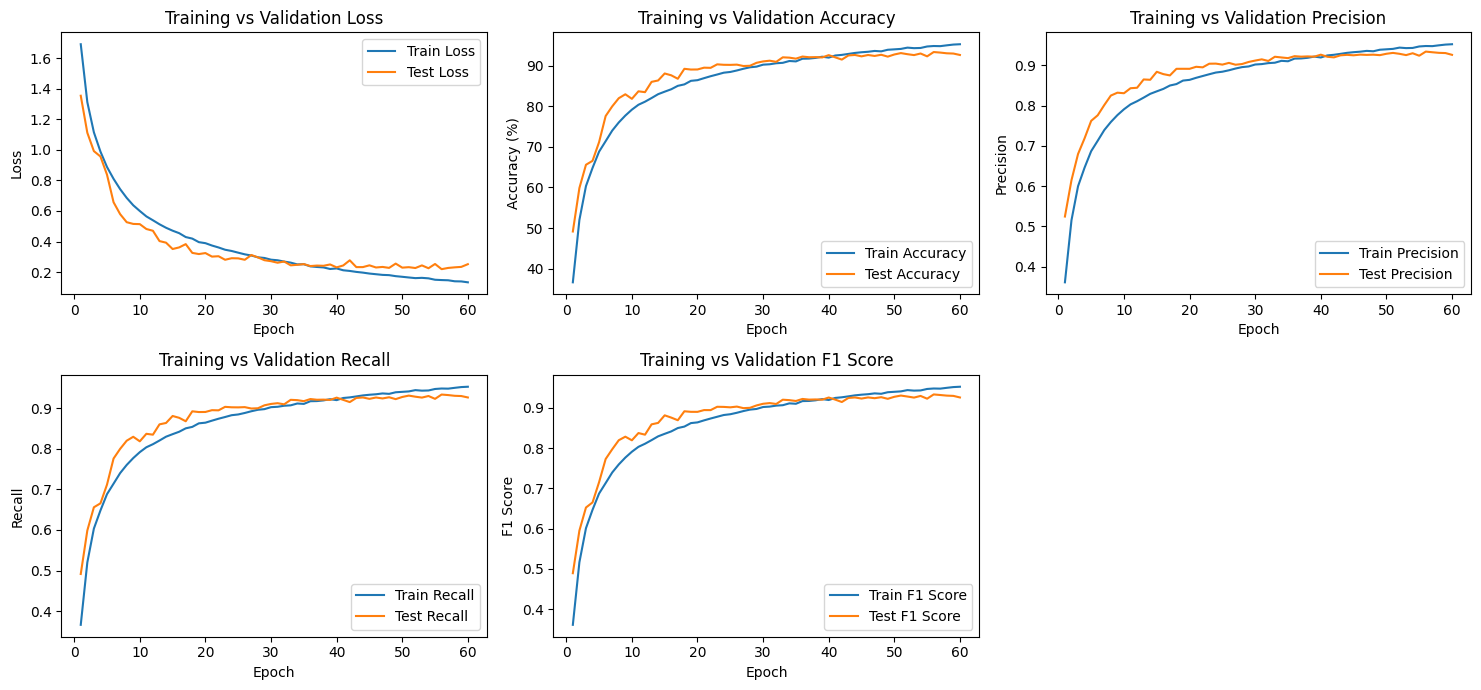

In [8]:
# Generate epoch numbers for x-axis
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(15,7))  

# Loss comparison plot
plt.subplot(2,3,1)  
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy comparison plot
plt.subplot(2,3,2) 
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Precision comparison plot
plt.subplot(2,3,3)  
plt.plot(epochs_range, train_precisions, label='Train Precision')
plt.plot(epochs_range, test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs Validation Precision')
plt.legend()

# Recall comparison plot
plt.subplot(2,3,4)  
plt.plot(epochs_range, train_recalls, label='Train Recall')
plt.plot(epochs_range, test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()

# F1 Score comparison plot
plt.subplot(2,3,5) 
plt.plot(epochs_range, train_f1s, label='Train F1 Score')
plt.plot(epochs_range, test_f1s, label='Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training vs Validation F1 Score')
plt.legend()


plt.tight_layout()  # Prevent label overlap
plt.savefig("training_curves.png", dpi=300, bbox_inches='tight') 
plt.show()


# Inference

In [9]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [10]:
test_data_dict = unpickle('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

print(test_data_dict.keys())
test_images = test_data_dict[b'data']
test_ids = test_data_dict[b'ids']

print(f"Test images shape: {test_images.shape}")

dict_keys([b'data', b'ids'])
Test images shape: (10000, 32, 32, 3)


In [11]:
class TestDataset(Dataset):
    def __init__(self, images, ids, transform=None):
        self.images = images
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_array = self.images[idx]
        img = Image.fromarray(img_array.astype('uint8'))  # Convert to PIL image
        
        if self.transform:
            img = self.transform(img) 

        return img, self.ids[idx]  


In [12]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616))
])

test_dataset = TestDataset(test_images, test_ids, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetMini(num_classes=10)

state_dict = torch.load('/kaggle/working/resnet_mini_cifar10_finetuned_v1.pth', map_location=device)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.to(device)

<ipython-input-13-8f2643488408>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/resnet_mini_cifar10_finetuned_v1.pth', map_location

ResNetMini(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (gelu): GELU(approximate='none')
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu): GELU(approximate='none')
      (relu): ReLU()
      (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [14]:
predictions = []
image_ids = []

model.eval()
with torch.no_grad():
    for images, ids in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids.numpy())

submission_df = pd.DataFrame({'ID': image_ids, 'Labels': predictions})
submission_df.to_csv('submission.csv', index=False)

100%|██████████| 79/79 [00:05<00:00, 15.25it/s]


In [15]:
submission_df = pd.DataFrame({
    'ID': image_ids,
    'Labels': predictions
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


# Visual Inspection

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid

<ipython-input-17-938fcdba6366>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


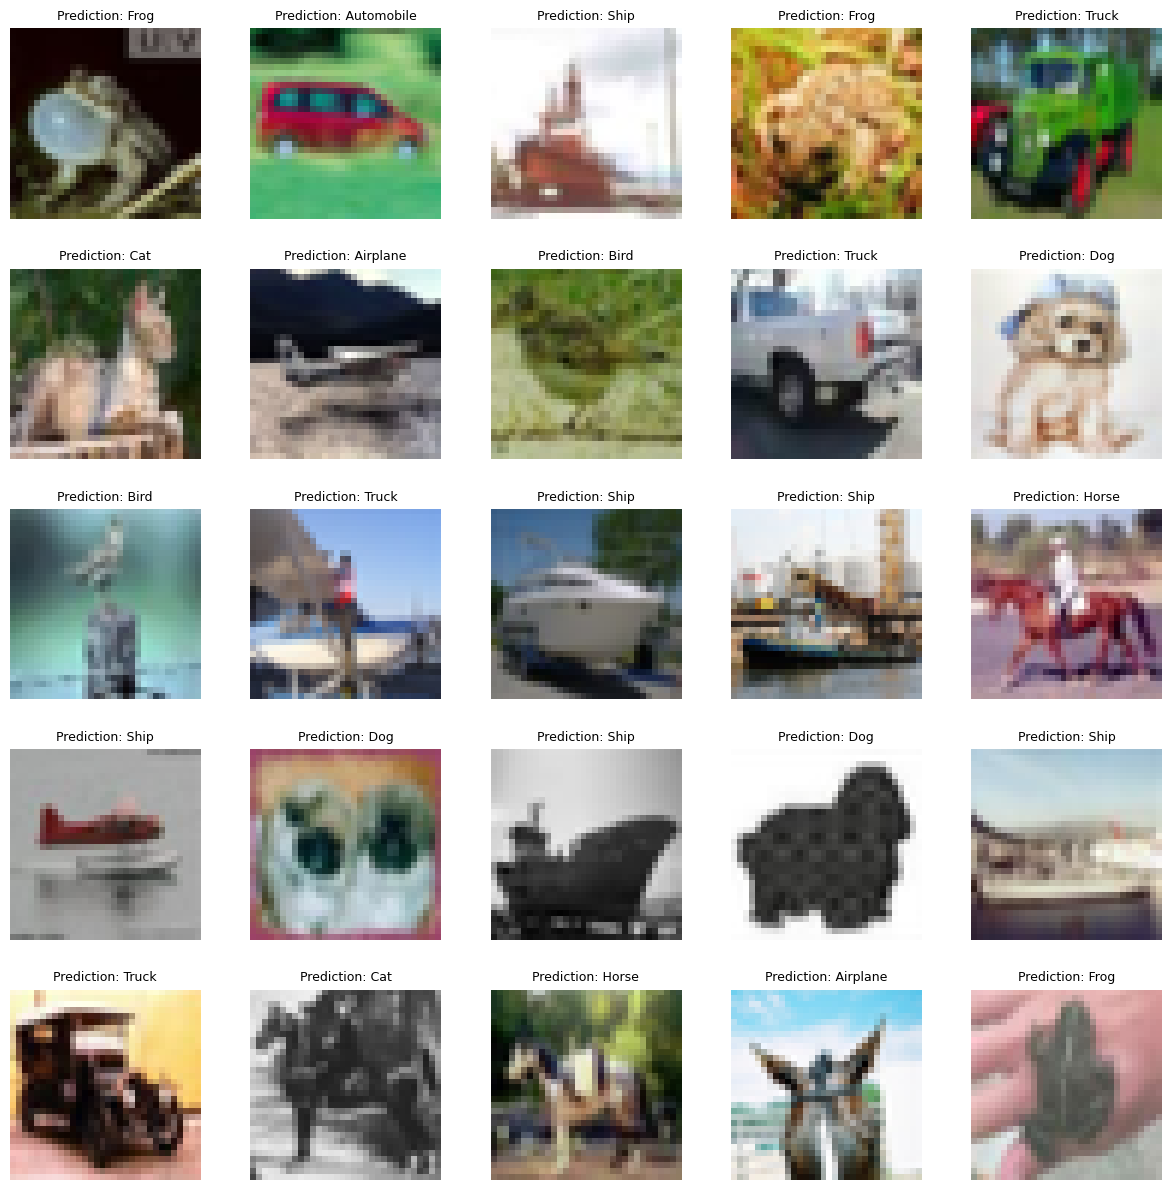

In [17]:
# Class labels mapping
class_names = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}


selected_images = test_images[:25]  
selected_ids = test_ids[:25]          
selected_preds = predictions[:25]     

# Create image grid layout
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111, 
                nrows_ncols=(5, 5),   # 5x5 grid for 25 samples
                axes_pad=0.5)         

# Plot each image with prediction overlay
for ax, img, pred in zip(grid.axes_all, selected_images, selected_preds):
    ax.imshow(img)  
    ax.set_title(f"Prediction: {class_names[pred]}", fontsize=9)
    ax.axis('off') 
    

plt.tight_layout()
plt.savefig("predictions_grid.png", dpi=300, bbox_inches='tight')  
plt.show()
